# Evaluate classifier performace metrics

Single-number evaluation metrics to investigate are accuracy, precision, recall, F1 score, AUC (Area Under the ROC Curve) score and Cohen’s Kappa.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit
seed = 0
def simulate_simple_dataset(weights):
    # simulate balanced binary dataset
    X, y = make_classification(n_samples=1000, n_features=20,
                                   n_informative=2, n_redundant=2,
                                   n_classes=2, weights=weights,
                                   random_state=seed
                              )
    # split dataset into training and test sets
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from imblearn.metrics import geometric_mean_score
import numpy as np

clf = SVC(kernel="linear",random_state=seed)

min_ratio = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
IR = [1,1.5,2.33,4,9,19,99]

class_scores = {}
avg_scores = {}
for i, r in enumerate(min_ratio):
    X_train, X_test, y_train, y_test = simulate_simple_dataset([1-r, r])
    std_clf = make_pipeline(StandardScaler(), clf)
    std_clf.fit(X_train, y_train)
    # evaluate for test set
    y_pred = std_clf.predict(X_test)
    conf_matrix = cm(y_test,y_pred, labels=[0,1], sample_weight=None)
    class_scores[IR[i]] = {'accuracy':np.divide(conf_matrix.diagonal(),conf_matrix.sum(axis=1), dtype=float),
                         'precision': precision_score(y_test,y_pred, average=None),
                         'recall': recall_score(y_test,y_pred, average=None),
                         'f1_score': f1_score(y_test,y_pred, average=None),
                         'G-mean':geometric_mean_score(y_test,y_pred, average=None)
                        }
    avg_scores[IR[i]] = [accuracy_score(y_test,y_pred, normalize=True, sample_weight=None),
                        precision_score(y_test,y_pred, average='weighted'), 
                        recall_score(y_test,y_pred, average='weighted'),
                        f1_score(y_test,y_pred, average='weighted'), 
                        roc_auc_score(y_test, y_pred, average='weighted'),
                        cohen_kappa_score(y_test, y_pred),
                        geometric_mean_score(y_test,y_pred, average='weighted')]

In [3]:
conf_matrix


array([[296,   0],
       [  3,   1]])

Cohen's Kappa: According to Wikipedia (citing their paper), Landis and Koch considers 0-0.20 as slight, 0.21-0.40 as fair, 0.41-0.60 as moderate, 0.61-0.80 as substantial, and 0.81-1 as almost perfect. Fleiss considers kappas > 0.75 as excellent, 0.40-0.75 as fair to good, and < 0.40 as poor. It is important to note that both scales are somewhat arbitrary.

In [4]:
class_1 = {}
class_0 = {}
IR = [1,1.5,2.33,4,9,19,99]
for i,k in enumerate(sorted(class_scores.keys())):
    class_1[k] = {}
    class_0[k] = {}
    for key in class_scores[k].keys():
        class_1[k][key] = round(class_scores[k][key][1],4)
        class_0[k][key] = round(class_scores[k][key][0],4)


In [5]:
import pandas as pd
df1 = pd.DataFrame.from_dict(class_0, orient='index')
df2 = pd.DataFrame.from_dict(class_1, orient='index')

In [6]:
df1 # class 0 (majority class)
df1 = df1.reindex(columns=['accuracy','precision','recall','f1_score','G-mean'])
df1

,accuracy,precision,recall,f1_score,G-mean
1.00,0.9536,0.9664,0.9536,0.9600,0.9600
1.50,0.9722,0.9259,0.9722,0.9485,0.9267
2.33,0.9713,0.9713,0.9713,0.9713,0.9525
4.00,0.9665,0.9747,0.9665,0.9706,0.9335
9.00,0.9963,0.9710,0.9963,0.9835,0.8598
19.00,0.9859,0.9790,0.9859,0.9825,0.7850
99.00,1.0000,0.9900,1.0000,0.9950,0.5000


In [7]:
df2 # class 1 (minority class)
df2 = df2.reindex(columns=['accuracy','precision','recall','f1_score','G-mean'])
df2

,accuracy,precision,recall,f1_score,G-mean
1.00,0.9664,0.9536,0.9664,0.9600,0.9600
1.50,0.8833,0.9550,0.8833,0.9177,0.9267
2.33,0.9341,0.9341,0.9341,0.9341,0.9525
4.00,0.9016,0.8730,0.9016,0.8871,0.9335
9.00,0.7419,0.9583,0.7419,0.8364,0.8598
19.00,0.6250,0.7143,0.6250,0.6667,0.7850
99.00,0.2500,1.0000,0.2500,0.4000,0.5000


In [8]:
df3 = pd.DataFrame.from_dict(avg_scores, orient='index')
df3.columns = ['accuracy', 'precision', 'recall', 'F1-score', 'ROC_AUC', 'kappa score','G-mean']
df3.sort_index(inplace=True)
df3

,accuracy,precision,recall,F1-score,ROC_AUC,kappa score,G-mean
1.00,0.960000,0.960085,0.960000,0.960000,0.960043,0.920004,0.960043
1.50,0.936667,0.937538,0.936667,0.936205,0.927778,0.866385,0.927735
2.33,0.960000,0.960000,0.960000,0.960000,0.952679,0.905358,0.952651
4.00,0.953333,0.954011,0.953333,0.953612,0.934083,0.857695,0.933885
9.00,0.970000,0.969704,0.970000,0.968284,0.869109,0.820144,0.863233
19.00,0.966667,0.964902,0.966667,0.965614,0.805458,0.649205,0.789160
99.00,0.990000,0.990100,0.990000,0.987025,0.625000,0.396783,0.507346


### Investigate the various options for averaging 

In [11]:
print('average=None') # scores for each class are returned. 
print([precision_score(y_test,y_pred, average=None), recall_score(y_test,y_pred, average=None),
f1_score(y_test,y_pred, average=None), roc_auc_score(y_test, y_pred, average=None)])

average=None
[array([0.98996656, 1.        ]), array([1.  , 0.25]), array([0.99495798, 0.4       ]), 0.625]


In [12]:
print('average=binary (default)') # Only report results for the class specified by pos_label. 
print([precision_score(y_test,y_pred, average='binary'), recall_score(y_test,y_pred, average='binary'),
f1_score(y_test,y_pred, average='binary')])
# average=binary not available for roc_auc_score

average=binary (default)
[1.0, 0.25, 0.4]


In [13]:
print('average=micro')# Calculate metrics globally by counting the total TP, FP and FN.
print([precision_score(y_test,y_pred, average='micro'), recall_score(y_test,y_pred, average='micro'),
f1_score(y_test,y_pred, average='micro'), roc_auc_score(y_test, y_pred, average='micro')])

average=micro
[0.99, 0.99, 0.99, 0.625]


In [14]:
print('average=macro') # Calculate metrics for each label, and find their unweighted mean. 
print([precision_score(y_test,y_pred, average='macro'), recall_score(y_test,y_pred, average='macro'),
f1_score(y_test,y_pred, average='macro'), roc_auc_score(y_test, y_pred, average='macro')])

average=macro
[0.9949832775919732, 0.625, 0.6974789915966386, 0.625]


In [15]:
print('average=weighted')
print([precision_score(y_test,y_pred, average='weighted'), recall_score(y_test,y_pred, average='weighted'),
f1_score(y_test,y_pred, average='weighted'), roc_auc_score(y_test, y_pred, average='weighted')])
# Calculate metrics for each label, and find their average, 
# weighted by support (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; it can result 
# in an F-score that is not between precision and recall.

average=weighted
[0.9901003344481605, 0.99, 0.9870252100840337, 0.625]


### Investigate geometric mean on binary and multiclass dataset

In [26]:
gmeans_binary = {}
avg_binary = {}
class_scores
for ir in IR:
    gmeans_binary[ir] = class_scores[ir]['G-mean']
    avg_binary[ir] = avg_scores[ir][-1]
df4 = pd.DataFrame.from_dict(gmeans_binary, orient='index')
df4.columns = ['class#1','class#2']
df4.sort_index(inplace=True) 
tmp = pd.DataFrame.from_dict(avg_binary, orient='index')
tmp.sort_index(inplace=True)
tmp.columns=['average']
df4['average'] = tmp['average']
df4

,class#1,class#2,average
1.00,0.960021,0.960021,0.960043
1.50,0.926713,0.926713,0.927735
2.33,0.952497,0.952497,0.952651
4.00,0.933520,0.933520,0.933885
9.00,0.859754,0.859754,0.863233
19.00,0.784982,0.784982,0.789160
99.00,0.500000,0.500000,0.507346


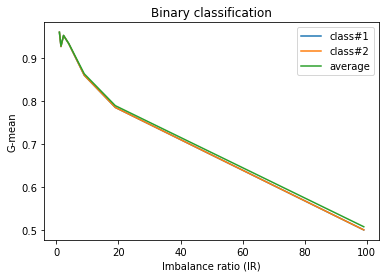

In [28]:
df4.plot()
plt.xlabel('Imbalance ratio (IR)')
plt.ylabel('G-mean')
plt.title('Binary classification')
plt.show()

In [30]:
gmeans = {}
avg = {}
for i, r in enumerate(min_ratio):
    X, y = make_classification(n_samples=1000, n_features=20,
                                   n_informative=3, n_redundant=2,
                                   n_classes=3, random_state=seed,
                                   weights=[(1-r)/2,(1-r)/2, r]
                              )
    # split dataset into training and test sets
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    std_clf = make_pipeline(StandardScaler(), clf)
    std_clf.fit(X_train, y_train)
    # evaluate for test set
    y_pred = std_clf.predict(X_test)
    gmeans[IR[i]] = geometric_mean_score(y_test,y_pred, average=None)
    avg[IR[i]] = geometric_mean_score(y_test,y_pred, average='weighted')
    

In [31]:
df5 = pd.DataFrame.from_dict(gmeans, orient='index')
df5.columns = ['class#1','class#2','class#3']
df5.sort_index(inplace=True) 

In [32]:
tmp = pd.DataFrame.from_dict(avg, orient='index')
tmp.sort_index(inplace=True)
tmp.columns=['average']
df5['average'] = tmp['average']
df5

,class#1,class#2,class#3,average
1.00,0.891987,0.821742,0.918836,0.891205
1.50,0.901914,0.846218,0.897091,0.884696
2.33,0.896146,0.854779,0.905539,0.885028
4.00,0.922205,0.885375,0.858859,0.895244
9.00,0.870311,0.833570,0.700847,0.839323
19.00,0.886403,0.879203,0.718673,0.876054
99.00,0.872946,0.866737,0.000000,0.865318


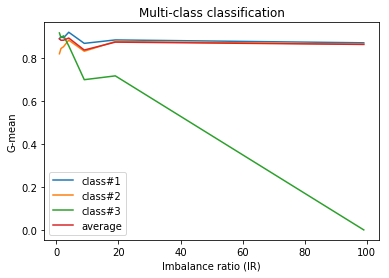

In [33]:
df5.plot()
plt.xlabel('Imbalance ratio (IR)')
plt.ylabel('G-mean')
plt.title('Multi-class classification')
plt.show()